# Comparison Between Confidence-Vector and Label-Only MIAs

### Threat Model:

- **Black Box** access to an overfitted classifier with no access to actual $D_{target}$
- Predict API returns **confidence vectors** (1st case) or **only labels instead of confidence vectors** (2nd case)
- We have some insight on the training data distribution, so the attacker will train on $D_{attacker}$ , **but** $D_{target} \cap D_{attacker} = \varnothing$
- We have zero insight in target's architecture


### Attack with confidence vectors: 
- Use a shadow model to attack local shadow models and extract membership leakage features
- Treat shadow models as targets and train on the produced confidence vectors, given the membership knowledge beforehand
- Train an attack model based on the prediction vector and target's confidence on predictions.
- Try to attack target model and infer-membership of instances

### Attack with labels:
- Target will return only the predicted label, trying to protect from any membership leakage.
- We use data perturbations in order to exploit test/training data approximation relevancies to the classification boundaries.
- We know that training data are more robust to perturbations (**check section::Extras**)
- We will use the perturbations to build a feature vector $\forall x \in D_{attacker}$, that is consisted from the true label, the predicted label and the predicted labels for al perturbations of given $x$.
- We will train an attack model on this dataset, given the ground truth our shadow models provide us with. 

### Evaluation Target
- Score over $50\%$ accuracy in each attack model
- Get a high $AUC$ score (prediction sensitivity)
- Compare the 2 attacks and prove that ommition of confidence vectors does not patch the models vulnerability.

Label-Only attack implemented based on [this paper](https://arxiv.org/abs/2007.14321).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from mia_v1.attack_model import *
from mia_v1.label_only import *
from mia_v1.shadow_models import *
from mia_v1.utilities import *
from mia_v1.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Target Model

Create a simple model that overfits, for exposition reasons.

In [ ]:
D_TARGET_SIZE = 2500

In [ ]:
def f_target(X_train, y_train, X_test=None, y_test=None, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  if X_test is None or y_test is None:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_split=0.2)
  else:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test))
  return model

Shuffle the dataset and divide it to 2 disjoint sets, $D_{target}$ and $D_{attacker}$.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

#shuffle the datasets
sample_i = np.random.choice(range(train_images.shape[0]), train_images.shape[0], replace=False)
train_images = train_images[sample_i]
train_labels = train_labels[sample_i]
sample_i = np.random.choice(range(test_images.shape[0]), test_images.shape[0], replace=False)
test_images = test_images[sample_i]
test_labels = test_labels[sample_i] 

# define the target's training dataset and the attacker's retrieved dataset
attacker_labels = np.concatenate((train_labels[D_TARGET_SIZE:], test_labels))
attacker_images = np.concatenate((train_images[D_TARGET_SIZE:], test_images))
target_images = train_images[:D_TARGET_SIZE]
target_labels = train_labels[:D_TARGET_SIZE]

In [ ]:
train_images, eval_images, train_labels, eval_labels = train_test_split(target_images, target_labels, test_size=0.2, shuffle=True)
target_model = f_target(train_images, train_labels, eval_images, eval_labels, epochs=25) 

Epoch 1/25
63/63 [==============================] - 5s 33ms/step - loss: 2.4417 - accuracy: 0.1455 - val_loss: 2.0587 - val_accuracy: 0.2280
Epoch 2/25
63/63 [==============================] - 1s 19ms/step - loss: 1.9701 - accuracy: 0.2530 - val_loss: 2.0294 - val_accuracy: 0.2020
Epoch 3/25
63/63 [==============================] - 1s 20ms/step - loss: 1.8307 - accuracy: 0.3145 - val_loss: 1.8177 - val_accuracy: 0.3560
Epoch 4/25
63/63 [==============================] - 1s 18ms/step - loss: 1.6840 - accuracy: 0.3580 - val_loss: 1.7540 - val_accuracy: 0.3680
Epoch 5/25
63/63 [==============================] - 1s 16ms/step - loss: 1.5604 - accuracy: 0.4120 - val_loss: 1.8259 - val_accuracy: 0.3280
Epoch 6/25
63/63 [==============================] - 1s 19ms/step - loss: 1.4907 - accuracy: 0.4395 - val_loss: 1.8100 - val_accuracy: 0.3620
Epoch 7/25
63/63 [==============================] - 1s 19ms/step - loss: 1.3841 - accuracy: 0.4845 - val_loss: 1.8268 - val_accuracy: 0.3300
Epoch 8/25
63

## Shadow Models

Set up a batch of shadow models to use in both attacks. We will use 5 shadow models, with 2500 instances assigned to each one of them.


In [ ]:
N_SHADOWS = 5
D_SHADOW_SIZE = 2500

In [ ]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))


  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

## Confidence Vector attack
Perform the attack and evaluate the results.

Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
class-1 acc: 0.7857142686843872
class-2 acc: 0.7555555701255798
class-3 acc: 0.8279816508293152
class-4 acc: 0.8571428656578064
class-5 acc: 0.7531806826591492
class-6 acc: 0.8369304537773132
class-7 acc: 0.762273907661438
class-8 acc: 0.8150851726531982
class-9 acc: 0.7622950673103333
class-10 acc: 0.800000011920929
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      2000
         1.0       0.79      0.81      0.80      2000

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000

AUC: 0.852005625


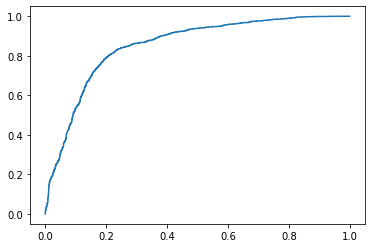

In [ ]:
attack = ConfidenceVectorAttack(target_model, (train_images, train_labels), (attacker_images, attacker_labels), f_shadow, 
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW_SIZE)
attack.perform_attack()
attack.evaluate_attack()

# Label Only Attack
Perform the attack, evaluate it and compare it with the *condifence vector* MIA.

Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
class-1 acc: 0.7609755992889404
class-2 acc: 0.76902174949646
class-3 acc: 0.8549222946166992
class-4 acc: 0.8417431116104126
class-5 acc: 0.8621553778648376
class-6 acc: 0.8254716992378235
class-7 acc: 0.7175572514533997
class-8 acc: 0.8024096488952637
class-9 acc: 0.7422680258750916
class-10 acc: 0.7795275449752808
              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78      2000
         1.0       0.75      0.88      0.81      2000

    accuracy                           0.80      4000
   macro avg       0.81      0.80      0.79      4000
weighted avg       0.81      0.80      0.79      4000

AUC: 0.819710875


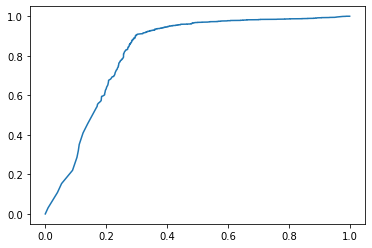

In [ ]:
def f_attack():
  model = models.Sequential(name='cifar10_label-only_attack-model')
  # input dims = 2*r(# of rotates - neutral)  + 4*d(# of translates - neutral) + 2 (y_pred, y_true)
  model.add(layers.Dense(10, input_shape=(2*3+4*1+2, )))
  model.add(layers.LeakyReLU(0.3))
  model.add(layers.Dense(1, activation='sigmoid'))
        
  model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
  
  print(model.summary())
  return model 

label_only_attack = LabelOnlyAttack(target_model, (train_images, train_labels), (attacker_images, attacker_labels), 
                                    rotates=3, translates=1, 
                                    attack_model_creator=f_attack,
                                    shadow_creator=f_shadow, 
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW_SIZE)
label_only_attack.perform_attack()
label_only_attack.evaluate_attack()

## Attack Comparison Results

